# A5: Multivariate Probability

---

*Purpose*: We've learned the basics about how to deal with random variables and how they interact, but we haven't talked about how random variables can be related. In this notebook we'll learn some fundamentals about random vectors, use these ideas to model a physical scenario, and apply these ideas to estimating the reliability of engineering systems.

*Learning Objectives*: By working through this assignment, you will 
- understand fundamental concepts about random vectors: linear correlation, marginals and copulas
- use these fundamental concepts to model a physically-relevant scenario
- understand the concepts of reliability & probability of failure
- use the First Order Reliability Method to approximate and design for reliability

*Reading*:
- (None required)
- Ch. 5 of [Owen](https://statweb.stanford.edu/~owen/mc/) has some details on "copula-marginal sampling"



### Assignment Checklist

1. [?] Make sure you have answered all questions. These are marked with a **qX.Y**
1. [?] Make sure you complete the Project Task at the end of the assignment. These will scaffold your project progress during the semester.
1. [?] Make sure your notebook passes all `assert()` statements. You will not get full credit for the assignment if a single `assert()` fails.
1. [?] Make sure your notebook runs: `Kernel > Restart kernel and run all cells...`
1. [?] Upload your notebook to Canvas.


### Grading Rubric

Every assignment is worth 10 points; it is not possible to receive less than 0 points. For each question (qX.Y) on a given assignment, the following grading rubric will be applied. For every NI that you receive, one point will be subtracted from your assignment total. For reference, to receive an A- in this class, you will need an average of 9 points across your 5 best assignments, meaning you need to have at most one mistake on your final submission for 5 assignments. To achieve this, you should take advantage of both the Draft and Final submission deadlines.

| Category     | Needs Improvement (NI)                     | Satisfactory (S)                       |
|--------------|--------------------------------------------|----------------------------------------|
| Effort       | qX.Y left unattempted                      | qX.Y attempted                         |
| Assertions   | Code does not pass an `assert()`           | All `assert()`s pass, or no assertions |
| Observations | Any point under *observe* left unattempted | All *observe*s attempted and correct,  |
|              | Provided an incorrect observation          | or no *observe*s for that q            |


## S1: Random Vectors

---

As an introduction to random vectors, we'll take another look at the RLC example from the previous notebook.


In [1]:
import grama as gr
import numpy as np
import scipy as sp
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import pandas as pd

from grama.models import make_prlc_rand

# Set figure options
plt.rcParams['figure.figsize'] = [6, 4]
plt.rcParams['figure.dpi'] = 100 # 200 e.g. is really fine, but slower

# Define the data pronoun as DF
DF = gr.Intention()

First, let's see what `Q, omega0` values we can obtain when we carefully control the `R, L, C` values and there is no manufacturing variability:


Text(0.5, 1.0, 'Controlled parameter sweeps')

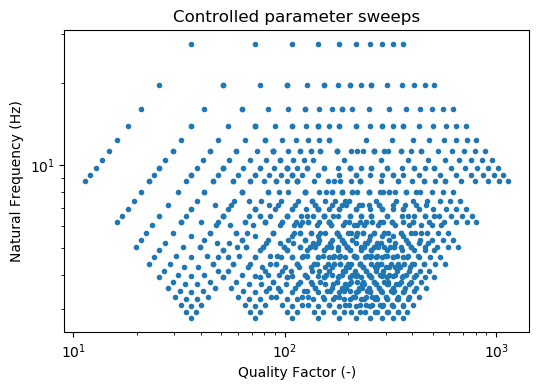

In [2]:
## NOTE: No need to edit
# Define the model
md_prlc = make_prlc_rand()
# Generate a grid of points in R, L, C
df_grid = (
    gr.df_make(L=np.linspace(1e-4, 1e-3, num=10))
    >> gr.tf_outer(gr.df_make(R=np.linspace(1e-1, 1e0, num=10)))
    >> gr.tf_outer(gr.df_make(C=np.linspace(1e1, 1e2, num=10)))
)
# Ignore tolerances; evaluate at nominal parameter values
df_grid_sweep = gr.eval_nominal(md_prlc, df_det=df_grid)

# Visualize
plt.figure()
plt.plot(
    df_grid_sweep.Q,
    df_grid_sweep.omega0,
    "."
)
plt.xscale("log")
plt.yscale("log")
plt.xlabel("Quality Factor (-)")
plt.ylabel("Natural Frequency (Hz)")
plt.title("Controlled parameter sweeps")


Note that we can reach arbitrary values of `Q, omega0` in this roughly-hexagonal area, and we seem to be limited only by the constraints we've imposed over `R, L, C`. Next let's see how uncertainty tends to affect values of `Q, omega0`.


### __q1.1__ How tolerances affect $Q, \omega_0$

Run the following code, inspect the results, and answer the questions under *Observe* below.


eval_monte_carlo() is rounding n...


Text(0.5, 1.0, 'Random variation')

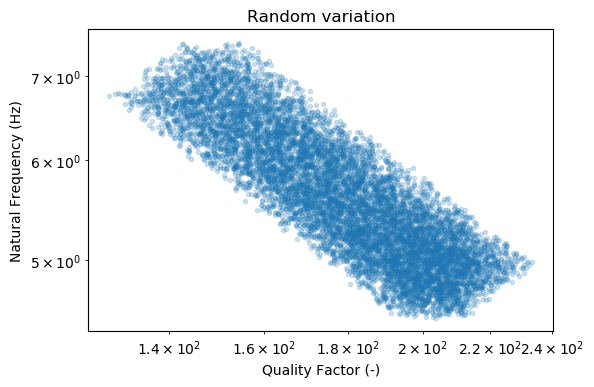

In [3]:
###
# TASK: Run the following code, inspect the results, and answer the questions below
###

## NOTE: No need to edit; run and inspect
# Draw a sample
df_prlc = gr.eval_monte_carlo(md_prlc,  n=1e4,  df_det="nom", seed=101)

# Visualize
plt.figure()
plt.plot(
    df_prlc.Q,
    df_prlc.omega0,
    ".",
    alpha=1/5
)
plt.xscale("log")
plt.yscale("log")
plt.xlabel("Quality Factor (-)")
plt.ylabel("Natural Frequency (Hz)")
plt.title("Random variation")

*Observe*

- As the quality factor `Q` increases, how does the natural frequency `omega0` *tend* to change?
  - `omega0` tends to decrease.
- If `Q` increases, is `omega0` *guaranteed* to decrease? Why or why not?
  - Because uncertaintity was introduced to the problem we can not say that it is guaranteed that an increase in Q will lead to a decrease in omega0.


### What's up with the coupled $Q, \omega_0$?

Remember that an *ideal* parallel RLC circuit has a natural frequency $\omega_0$ given by

$$\omega_0 = \sqrt{\frac{1}{LC}}$$

and its quality factor $Q$ is given by

$$Q = R\sqrt{\frac{C}{L}}.$$

Note that $C$ enters into the denominator of $\omega_0$ and the numerator of $Q$; **the capacitance $C$ tends to affect $Q$ and $\omega_0$ with opposite effect**. Since $C$ has much looser tolerances (Notebook 4), this coupling dominates the effects of $R, L$ and produces the *negative correlation* we saw above.


## Correlation

The relationship between $Q, \omega_0$ is an example of *correlation* between random variables. There are actually multiple varieties of correlation; the most common is *linear correlation*, also called the [pearson correlation](https://en.wikipedia.org/wiki/Pearson_correlation_coefficient). The pearson correlation is defined as

$$\rho_{X, Y} = \frac{\mathbb{E}[(X - \mu_X)(Y - \mu_Y)]}{\sigma_X \sigma_Y}$$

where the numerator is the expectation of the composite random variable $(X - \mu_X)(Y - \mu_Y)$, and the denominator is a normalizing factor equal to the product of the standard deviations $\sigma_X, \sigma_Y$. The pearson correlation is a dimensionless number that is bounded $\rho_{X, Y} \in [-1, +1]$, with $\rho_{X, Y} = +1$ indicating a strong *positive* linear relationship, $\rho_{X, Y} = -1$ indicating a strong *negative* linear relationship, and $\rho_{X, Y} = 0$ indicating no *linear* relationship.

With the $Q, \omega_0$ data we generated above, we can estimate a linear correlation coefficient:


In [4]:
## NOTE: No need to edit
(
    df_prlc
    >> gr.tf_summarize(rho=gr.corr(DF.Q, DF.omega0))
)

,rho
0,-0.849891


This quantitative result corroborates what we saw visually in q1.1: $\omega_0$ tends to decrease as $Q$ increases. Note that `rho != -1.0`, which also corroborates the "lack of guarantee" we saw in q1.1; the relationship between $Q, \omega_0$ is not perfectly linear, so `rho` falls short of the value `-1`.


*Aside*: Engineers tend to be *very sloppy* with the term "correlation", using it to describe any kind of relationship between variables. Note that the term "correlation" without caveat is reserved for *linear* correlation (formally, the [pearson correlation](https://en.wikipedia.org/wiki/Pearson_correlation_coefficient)). This is especially consequential when the underlying relationship his highly nonlinear, for example:


corr[X_quad, Y_quad] = 0.000


Text(0, 0.5, 'Y')

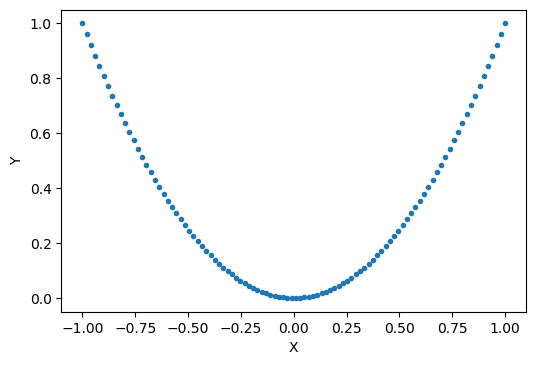

In [5]:
## NOTE: No need to edit
# Generate some data
X_quad = np.linspace(-1, +1, num=100)
Y_quad = X_quad ** 2
r_quad = gr.corr(X_quad, Y_quad)

print("corr[X_quad, Y_quad] = {0:4.3f}".format(r_quad))

# Visualize
plt.figure()
plt.plot(X_quad, Y_quad, ".")
plt.xlabel("X")
plt.ylabel("Y")


*Clearly*, the variables $X, Y$ have a strong *relationship*, but they have *zero correlation*. Note that you can always use the (more general) phrase "X is *related* to Y" rather than saying the (here false) statement "X is *correlated* with Y".


### Random Vectors

To date, we've talked primarily about individual random variables, such as $X \sim F_X$. However, we just saw that two random variables can have some relationship. This indicates that we should probably think about random variables *jointly* so we have some chance of describing this relationship. To that end, we can think about *random vectors*: random quantities with multiple values that have a *joint density*.

For instance we could think about a random two-dimensional vector $V = [X, Y]$ where each component of the vector has its own *marginal distribution* $X \sim F_X$ and $Y \sim F_Y$. However the two also have a *joint density* $[X, Y] \sim F_{X, Y}$, and the marginal distributions can be computed from this joint density (called [marginalizing](https://en.wikipedia.org/wiki/Marginal_distribution)).


### The multivariate normal distribution

The most common example of a random vector is the [multivariate normal](https://en.wikipedia.org/wiki/Multivariate_normal_distribution); not necessarily because it's a good model for every scenario, but primarily because it is *relatively easy to understand*.

A multivariate normal $X \sim N(\mu, \Sigma)$ with $d$ components (also called a multivariate gaussian) has normal distributions for all its marginals $X_i \sim N(\mu_{X_i}, \sigma_{X_i}^2)$, and a correlation matrix to describe the pairwise correlations between all its components $R_{ij} = \rho_{X_i, X_j}$. It turns out these few pieces of information---the vector mean $\mu_X = [\mu_{X_1}, \dots, \mu_{X_d}]$, the variances $\sigma_i^2$, and the correlation matrix $R$---fully define the distribution.

Frequently we combine the correlation and variances into the *variance-covariance matrix*, which in two dimensions is given by

$$\Sigma = \left[\begin{array}{cc} \sigma_{X_1}^2 & \rho_{X_1 X_2} \sigma_{X_1} \sigma_{X_2} \\  \rho_{X_1 X_2} \sigma_{X_1} \sigma_{X_2} & \sigma_{X_2}^2 \end{array}\right]$$

and [more generally](https://en.wikipedia.org/wiki/Covariance_matrix#Relation_to_the_correlation_matrix) can be constructed via $\Sigma = \text{Diag}([\sigma_1, \dots, \sigma_d]) \,R\, \text{Diag}([\sigma_1, \dots, \sigma_d])$.

There is of course a [messy formula](https://en.wikipedia.org/wiki/Multivariate_normal_distribution#Density_function) for the joint density of this random vector, but rather than obsess over formulas, let's instead work towards some intuition for how the multivariate normal behaves:


eval_monte_carlo() is rounding n...
Design runtime estimates unavailable; model has no timing data.
eval_monte_carlo() is rounding n...
Design runtime estimates unavailable; model has no timing data.


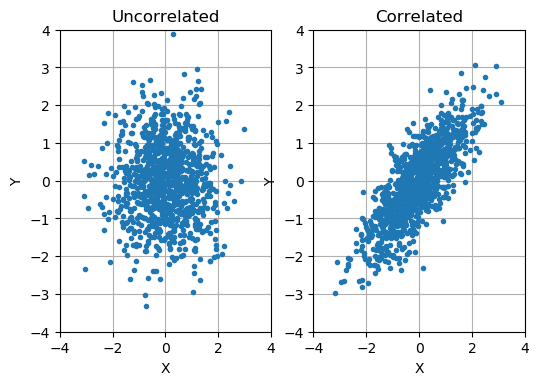

In [6]:
## NOTE: No need to edit; run and inspect
# Uncorrelated gaussian
md_no_corr = (
    gr.Model("Uncorrelated gaussian")
    >> gr.cp_marginals(
        x=dict(dist="norm", loc=0, scale=1),
        y=dict(dist="norm", loc=0, scale=1),
    )
    # NOTE: Here we assume the `x, y` are independent
    >> gr.cp_copula_independence()
)

# Correlated gaussian
md_corr = (
    gr.Model("Uncorrelated gaussian")
    >> gr.cp_marginals(
        x=dict(dist="norm", loc=0, scale=1),
        y=dict(dist="norm", loc=0, scale=1),
    )
    # NOTE: Here we provide a finite correlation between `x, y`
    >> gr.cp_copula_gaussian(df_corr=gr.df_make(corr=0.8, var1="x", var2="y"))
)

# Draw realizations
df_no_corr = gr.eval_monte_carlo(md_no_corr, n=1e3, df_det="nom", skip=True, seed=101)
df_corr = gr.eval_monte_carlo(md_corr, n=1e3, df_det="nom", skip=True, seed=101)

# Visualize
fig, (ax1, ax2) = plt.subplots(1, 2)
ax1.plot(
    df_no_corr.x,
    df_no_corr.y,
    "."
)
ax1.set(xlabel="X", ylabel="Y", title="Uncorrelated")
ax1.set_xlim(-4, +4)
ax1.set_ylim(-4, +4)
ax1.grid()
ax2.plot(
    df_corr.x,
    df_corr.y,
    "."
)
ax2.set(xlabel="X", ylabel="Y", title="Correlated")
ax2.set_xlim(-4, +4)
ax2.set_ylim(-4, +4)
ax2.grid()

Note that the uncorrelated case results in spherically-distributed samples, while the correlated case results in samples that tend to---but don't perfectly---lie on a line.


Grama provides tools to fit a distribution to data. For reasons we'll discuss in a bit, Grama breaks this into two pieces:

1. Fit marginals with `gr.marg_named()` for each entry of the random vector
2. Fit a *gaussian copula* with `gr.copula_gaussian()` to relate all entries of the random vector
  - (We'll discuss *copulas* in a bit....)

The setting `"norm"` for `gr.marg_named()` will fit a normal marginal; using normal distributions for every marginal with a *gaussian copula* is equivalent to fitting a multivariate normal.

### __q1.2__ Visually assess a fitted Gaussian

The following code fits a multivariate gaussian to the `Q, omega0` data. Run the code, inspect the results, and answer the questions under *Observe* below.


eval_monte_carlo() is rounding n...
Design runtime estimates unavailable; model has no timing data.


(4, 8)

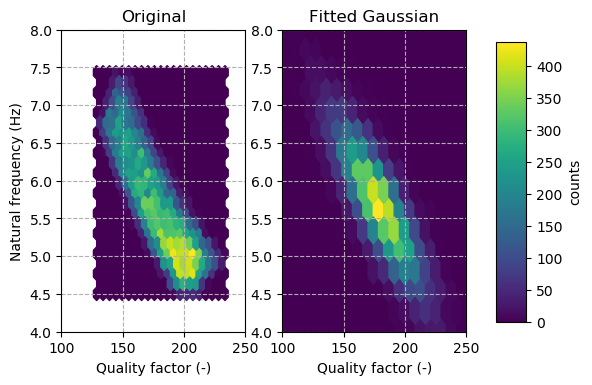

In [7]:
###
# TASK: Run this chunk and analyze the results
###

## NOTE: No need to edit; run this chunk, inspect the results, answer the questions
# This code fits a model for the random vector [Q, omega0]
md_prlc_norm = (
    gr.Model()
    >> gr.cp_marginals(
        # Fit a "norm" (normal == gaussian) distribution for Q
        Q=gr.marg_named(df_prlc.Q, "norm"),
        # Fit a "norm" (normal == gaussian) for omega0
        omega0=gr.marg_named(df_prlc.omega0, "norm"),
    )
    # Fit a gaussian copula to introduce dependence
    >> gr.cp_copula_gaussian(df_data=df_prlc)
)

# Draw realizations from random vector model
df_prlc_norm = gr.eval_monte_carlo(md_prlc_norm, n=1e4, df_det="nom", skip=True, seed=101)

# Visually compare the original data with realizations from the fitted model
fig, (ax1, ax2) = plt.subplots(1, 2)
hb1 = ax1.hexbin(df_prlc.Q, df_prlc.omega0, gridsize=20, cmap="viridis")
hb2 = ax2.hexbin(df_prlc_norm.Q, df_prlc_norm.omega0, gridsize=20, cmap="viridis")

fig.subplots_adjust(right=0.8)
cbar_ax = fig.add_axes([0.85, 0.15, 0.05, 0.7])
cb = fig.colorbar(hb2, cax=cbar_ax)

cb.set_label('counts')
ax1.set(xlabel="Quality factor (-)", ylabel="Natural frequency (Hz)", title="Original")
ax1.grid(linestyle="--")
ax1.set_xlim(100, 250)
ax1.set_ylim(4, 8)
ax2.set(xlabel="Quality factor (-)", title="Fitted Gaussian")
ax2.grid(linestyle="--")
ax2.set_xlim(100, 250)
ax2.set_ylim(4, 8)

*Observe*

- What aspects of the original data does the `Fitted Gaussian` get *correct*?
  - The fitted gaussian accurately reflects the negative relationship between quality factor and natural frequency.
- What aspects of the original data does the `Fitted Gaussian` get *wrong*?
  - The fitted gaussian does not accurately reflect the density of the points in the distribution. This probably also indictates that the mean values for and standard deviation of the data is wrong as well.
- Is a multivariate gaussian sufficient to represent the original data *perfectly*? Why or why not?
  - Perfectly is a strong word. The represenation does not perfectly reflect the original data because the density of the points in the distribution and mean are incorrect. 


### Fit a Marginal

Let's check the shape of the `omega0` marginal:


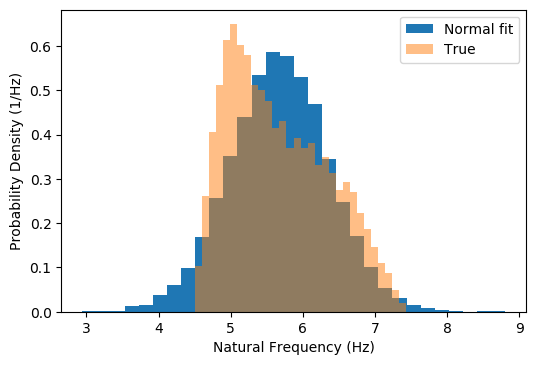

In [8]:
## NOTE:
plt.figure()
plt.hist(df_prlc_norm.omega0, bins=30, density=True, label="Normal fit")
plt.hist(df_prlc.omega0, bins=30, alpha=1/2, density=True, label="True")
plt.xlabel("Natural Frequency (Hz)")
plt.ylabel("Probability Density (1/Hz)")
plt.legend(loc=0)


Here we can see some of the limitations of the normal model: The normal is too symmetric and its tails too long. The underlying uncertainties (tolerances) are bounded; since there are no singularities the output uncertainty should be bounded too. 

The [beta](https://en.wikipedia.org/wiki/Beta_distribution) distribution is a bounded distribution. Let's try fitting a beta marginal to the `omega0` data instead; Grama makes swapping out the distribution easy:


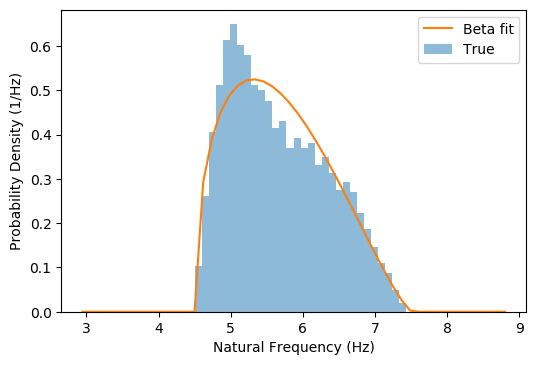

In [9]:
# Fit a beta distribution
dist_beta = gr.marg_named(df_prlc.omega0, "beta")
x_beta = np.linspace(df_prlc_norm.omega0.min(), df_prlc_norm.omega0.max())
d_beta = [dist_beta.l(x) for x in x_beta]

# Visually compare against true data
plt.figure()
plt.hist(df_prlc.omega0, bins=30, alpha=1/2, density=True, label="True")
plt.plot(x_beta, d_beta, label="Beta fit")
plt.xlabel("Natural Frequency (Hz)")
plt.ylabel("Probability Density (1/Hz)")
plt.legend(loc=0)


The beta fit is still not perfect, but it improves on the deficiencies of the normal fit; it's asymmetric like the underlying data, and it does a good job capturing the tail behavior of the true data.

However, we now have a problem: We only know how to impose correlations using a gaussian distribution. To stitch together a solution, we can apply the *quantile trick*.


### The Quantile Trick

If we have a source of uniform random variables $U \sim U[0, 1]$, then we can transform them to have a different distribution $X \equiv F_X^{-1}(U) \sim F_X$. Thus we can transform samples from a uniform random variable to draw samples from an arbitrary density, so long as we have its quantile function. The marginal we fit above provides a marginal distribution, so we can apply the quantile trick:


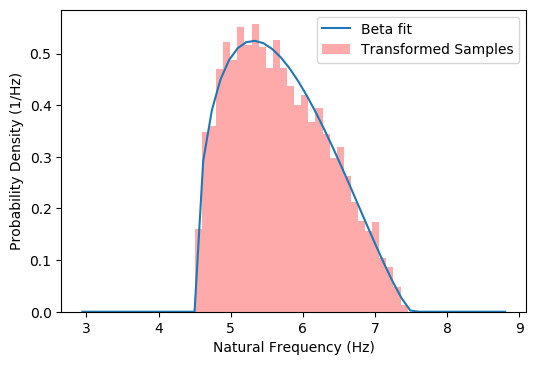

In [10]:
## NOTE: No need to edit; this
# Samples from a uniform distribution
X_unif = np.random.random(size=5000)
# Transform samples with the quantile function to match a given distribution
X_beta = [dist_beta.q(x) for x in X_unif]

# Visually compare against true data
plt.figure()
plt.hist(X_beta, color="red", alpha=1/3, bins=30, density=True, label="Transformed Samples")
plt.plot(x_beta, d_beta, label="Beta fit")
plt.xlabel("Natural Frequency (Hz)")
plt.ylabel("Probability Density (1/Hz)")
plt.legend(loc=0)


What this means is we can use the quantile trick to use $[0, 1]$ as a "reference domain" and give samples an arbitrary shape. If only we could generate correlated samples on the square $[0, 1]^2$, we could transform each marginal with shapes for `Q, omega0` to build up our model. A *copula* is an object that will give us correlated samples on a square $[0, 1]^2$, or indeed any unit box $[0, 1]^d$.


### Coupling the Marginals with a Copula

A copula is essentially a joint density on the unit square $[0, 1]^d$. It allows us to *couple* a set of marginals using the quantile trick. A [gaussian copula](https://en.wikipedia.org/wiki/Copula_(probability_theory)#Gaussian_copula) is one of the most common forms of copula.

The idea is the following; if we have samples from a multivariate gaussian $Z \sim N(0, \Sigma)$ with a variance matrix $\Sigma$ that has all unit variances but (possibly) non-zero correlations, then we can map each of its components $Z_i$ with the quantile trick. Applying the standard normal CDF to each sample gives us a uniform variable

$$U_i = \Phi(Z_i) \sim U[0, 1]$$

which we can then map to our desired marginal

$$F_i = F_{X_i}^{-1}(\Phi(Z_i)) \sim F_X.$$

The following illustrates two gaussian copulas; one without correlation, and one with negative correlation.


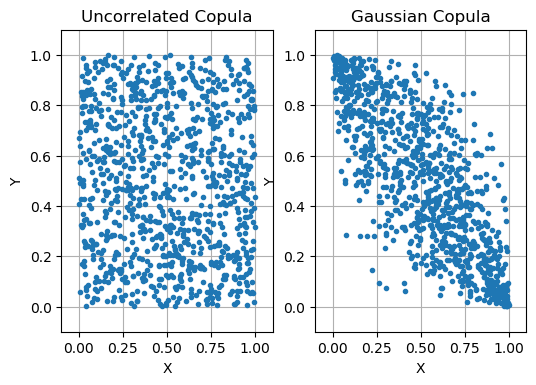

In [11]:
# Generate samples from two copulas
cop_ind = gr.CopulaGaussian(
    ["Q", "omega0"], 
    gr.df_make(var1=["Q"], var2=["omega0"], corr=0.0)
)
df_ind = cop_ind.sample(n=1000)
cop_gauss = gr.CopulaGaussian(
    ["Q", "omega0"], 
    gr.df_make(var1=["Q"], var2=["omega0"], corr=-0.8)
)
df_gauss = cop_gauss.sample(n=1000)

# Visualize
fig, (ax1, ax2) = plt.subplots(1, 2)
ax1.plot(df_ind.Q, df_ind.omega0, ".")
ax1.set(xlabel="X", ylabel="Y", title="Uncorrelated Copula")
ax1.set_xlim(-0.1, 1.1)
ax1.set_ylim(-0.1, 1.1)
ax1.grid()
ax2.plot(df_gauss.Q, df_gauss.omega0, ".")
ax2.set(xlabel="X", ylabel="Y", title="Gaussian Copula")
ax2.set_xlim(-0.1, 1.1)
ax2.set_ylim(-0.1, 1.1)
ax2.grid()


With this set of coupled samples on $[0, 1]^d$, we can use the quantile trick to add the correct shape for each individual marginal.

This framework is theoretically justified by [Skylar's theorem](https://en.wikipedia.org/wiki/Copula_(probability_theory)#Sklar's_theorem), which states that **any** joint density can be expressed in terms of marginals and a copula.

Grama provides tools to help you focus less on the implementation details and more on the important modeling decisions. Once you choose appropriate marginals for each random input, you can use `gr.cp_copula_gaussian()` to estimate a gaussian copula from data.


### __q1.3__ Fit and inspect a copula model

Use the data `df_prlc` to estimate a random vector model for `Q, omega0`. Use beta marginals and fit a gaussian copula to account for dependency. Answer the questions below.

*Hint*: You should use code from q1.2 as a starting point.


eval_monte_carlo() is rounding n...
Design runtime estimates unavailable; model has no timing data.


(4, 8)

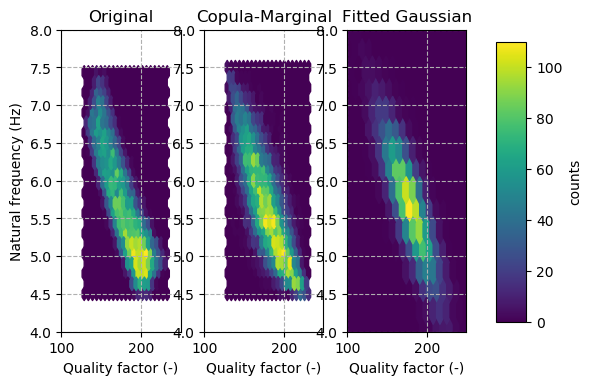

In [12]:
###
# TASK: Fit a copula model with "beta" marginals
# HINT: Make sure to use the `df_data` argument with `gr.cp_copula_gaussian()`
###

## TASK: Construct your copula model
# md_prlc_beta = ???
md_prlc_beta = (
    gr.Model()
    >> gr.cp_marginals(
        # Fit a "norm" (normal == gaussian) distribution for Q
        Q=gr.marg_named(df_prlc.Q, "beta"),
        # Fit a "norm" (normal == gaussian) for omega0
        omega0=gr.marg_named(df_prlc.omega0, "beta"),
    )
    # Fit a gaussian copula to introduce dependence
    >> gr.cp_copula_gaussian(df_data=df_prlc)
)


## NOTE: No need to edit below; this will compare results from three models
# Draw realizations from random vector model
df_prlc_beta = gr.eval_monte_carlo(md_prlc_beta, n=1e4, df_det="nom", skip=True, seed=101)

# Visually compare the original data with realizations from the fitted model
fig, (ax1, ax2, ax3) = plt.subplots(1, 3)
hb1 = ax1.hexbin(df_prlc.Q, df_prlc.omega0, gridsize=20, cmap="viridis")
hb2 = ax2.hexbin(df_prlc_beta.Q, df_prlc_beta.omega0, gridsize=20, cmap="viridis")
hb3 = ax3.hexbin(df_prlc_norm.Q, df_prlc_norm.omega0, gridsize=20, cmap="viridis")

fig.subplots_adjust(right=0.8)
cbar_ax = fig.add_axes([0.85, 0.15, 0.05, 0.7])
cb = fig.colorbar(hb2, cax=cbar_ax)

cb.set_label('counts')
ax1.set(xlabel="Quality factor (-)", ylabel="Natural frequency (Hz)", title="Original")
ax1.grid(linestyle="--")
ax1.set_xlim(100, 250)
ax1.set_ylim(4, 8)

ax2.set(xlabel="Quality factor (-)", title="Copula-Marginal")
ax2.grid(linestyle="--")
ax2.set_xlim(100, 250)
ax2.set_ylim(4, 8)

ax3.set(xlabel="Quality factor (-)", title="Fitted Gaussian")
ax3.grid(linestyle="--")
ax3.set_xlim(100, 250)
ax3.set_ylim(4, 8)

*Observe*

- Is a gaussian copula with the chosen marginals sufficient to represent the original data *perfectly*? If no, what deficiencies does it have?
  - No, the density of the distribution, mean, and standard deviation are not identical. 
- What features of the original data does the model get right?
  - The relationship between quality factor and natural frequency. The mean and variance is also closer to the original data.


At the end of the day, the point of probability modeling is not to make pretty matching pictures, but rather to help us accurately answer questions. We'll finish up this section by comparing how well the models above help us answer particular (quantitative) questions.


### __q1.4__ Compare models for a given purpose

Study the following results and answer the questions below.


In [13]:
###
# TASK: The following code compares quantitative results from
#       multiple sources; study the results and answer the
#       questions
###

## NOTE: No need to edit
# Evaluate nominal omega0
df_nom = gr.eval_nominal(md_prlc, df_det="nom")
omega0_nom = float(df_nom.omega0[0])

# Compare statistics
(
    df_prlc
    >> gr.tf_mutate(source="true")
    >> gr.tf_bind_rows(
        df_prlc_norm
        >> gr.tf_mutate(source="norm")
    )
    >> gr.tf_bind_rows(
        df_prlc_beta
        >> gr.tf_mutate(source="copula")
    )
    >> gr.tf_group_by(DF.source)
    >> gr.tf_summarize(
        Q_mean=gr.mean(DF.Q),
        omega0_mean=gr.mean(DF.omega0),
        rho_Q_omega0=gr.corr(DF.Q, DF.omega0),
        pr=gr.mean((omega0_nom * 0.95 <= DF.omega0) & (DF.omega0 <= omega0_nom * 1.05)),
    )
)


,source,Q_mean,omega0_mean,rho_Q_omega0,pr
0,copula,179.064330,5.683512,-0.807808,0.2816
1,norm,179.165849,5.673942,-0.850222,0.3119
2,true,179.408491,5.668338,-0.849891,0.2554


*Observe*:

- Suppose our goal with modeling the distribution of `Q, omega0` was to accurately estimate their means and correlation. Between `norm` and `copula`, which model would you prefer, and why?
  - norm because the means and correlations for the norm distribution are closer to the true values. 
- Suppose our goal with modeling the distribution of `Q, omega0` was to accurately estimate the probability that `omega0` lie within $\pm5\%$ of its nominal value (the `pr` column). Between `norm` and `copula`, which model would you prefer, and why?
  - copula because the pr value is closer to the true value.


## S2: Probability modeling

---

Probability modeling *feels* different from physical modeling. The "valid moves" are different from the approximations we're used to making in an engineering context, e.g. linearizing a term because fluctuations are small. To give you a concrete sense about some of the "valid moves" in probability modeling, you'll work through a concrete example below.

**Our objective** in this exercise is to *accurately* model the tensile yield strength (TYS) and tensile ultimate strength (TUS) of an aircraft-grade cast steel alloy. As we'll see in Section 3 below, this kind of probability model is useful for assessing the reliability of safety-critical systems.

The following are data from a report by Ruff (1984) detailing the study of a cast stainless steel for aerospace purposes. The following shows the head of the data:


In [14]:
## NOTE: No need to edit; df_ruff is built-into Grama
from grama.data import df_ruff
df_ruff.head()

,part,TYS,TUS,thickness
0,aa,157.0,164.7,0.485
1,ab,159.6,168.2,0.625
2,ac,155.6,165.4,0.625
3,ha,165.8,174.0,0.375
4,hb,157.4,163.8,1.000


### __q2.1__ Get the basic facts

Inspect the Ruff dataset and answer the questions below.

*Hint*: Every Pandas dataframe has the attributes `df.columns` and `df.shape`. Use these below.


In [15]:
###
# TASK: Inspect df_ruff and answer the questions below
###

# print(df_ruff.columns)
# print(df_ruff.shape)

print(df_ruff)



   part    TYS    TUS  thickness
0    aa  157.0  164.7      0.485
1    ab  159.6  168.2      0.625
2    ac  155.6  165.4      0.625
3    ha  165.8  174.0      0.375
4    hb  157.4  163.8      1.000
5    hc  158.4  164.6      0.500
6    hd  157.6  167.3      0.150
7    ba  156.4  161.7      3.000
8    bb  157.7  162.7      3.000
9    ga  155.7  164.4      0.500
10   gb  158.8  163.6      0.500
11   gc  158.1  165.1      0.500
12   gd  157.0  165.8      0.500
13   ge  154.8  164.1      0.500
14   gf  156.1  163.2      0.375


*Observe*:

- What columns does this dataset have?
  - ['part', 'TYS', 'TUS', 'thickness']
- How many observations (individual parts) does this dataset consider?
  - 15


Here are some facts about `df_ruff` that are *not* apparent just from inspection:

- `part` part identifier
- `TYS` tensile yield strength, in ksi (kilo-pounds per square inch). Averaged over two coupons
- `TUS` tensile ultimate strength, in ksi. Averaged over two coupons
- `thickness` thickness of tested coupons

I learned this by reading the paper that has the data: You'll have to do the same for any data / information you gather for your project.

A standard _assumption_ made with structural materials is that properties like strength *do not vary* with thickness. If this assumption holds---and if individual parts are manufactured according to a similar process---then we could use each observation of the material strength(s) to fit a distribution. You will check the thickness assumption below.


### __q2.2__ Check assumptions

Check if TYS varies with thickness; answer the questions below.


Text(0, 0.5, 'Tensile Yield Strength (ksi)')

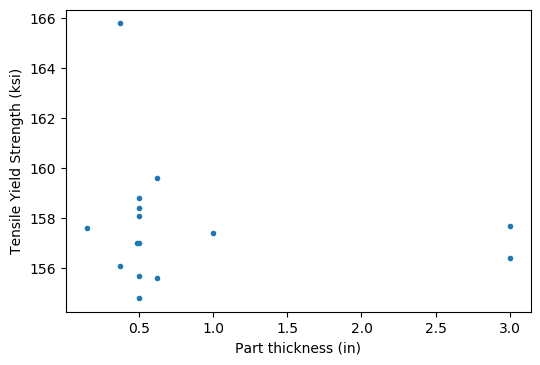

In [16]:
###
# TASK: Inspect the following results, answer the questions below
###

## NOTE: No need to edit; run and inspect
plt.plot(df_ruff.thickness, df_ruff.TYS, ".")
plt.xlabel("Part thickness (in)")
plt.ylabel("Tensile Yield Strength (ksi)")


*Observe*:

- Based on the data above, does TYS appear to vary with thickness? (yes or no)
  - yes
- Justify your yes or no answer above.
  - There's really not enough data to know for certain but the tensile yield strength has larger values with a thinner part thickness. 


### Building models that respect physics

Our goal is to build an *accurate* model; part of the accuracy of this (random variable) model is that it should respect known physical principles: Remember that [yielding](https://en.wikipedia.org/wiki/Yield_(engineering)) is a kind of structural deformation where the part begins to deform irreversibly, while an [ultimate](https://en.wikipedia.org/wiki/Ultimate_tensile_strength) failure is where a part breaks completely. From this, we can highlight two physical principles:

1. A strength---TYS or TUS---must be non-negative
2. The ultimate strength must be larger than the yield strength

The second observation is something we can express probabilistically; TUS and TYS should be positively correlated. We will seek to represent this accurately in our probability model. Our first step will be to check that this behavior exists in the data.


### __q2.3__ Inspect the data

Inspect the TUS vs TYS data, answer the questions below.


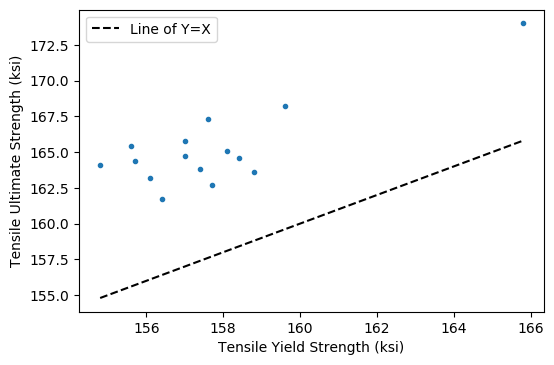

In [17]:
###
# TASK: Inspect the following, answer the questions below
###

## NOTE: No need to edit; run and inspect
plt.plot(df_ruff.TYS, df_ruff.TUS, ".")
plt.plot(
    [df_ruff.TYS.min(), df_ruff.TYS.max()],
    [df_ruff.TYS.min(), df_ruff.TYS.max()],
    "k--",
    label="Line of Y=X"
)
plt.xlabel("Tensile Yield Strength (ksi)")
plt.ylabel("Tensile Ultimate Strength (ksi)")
plt.legend(loc=0)

print()

*Observe*:

- What---if any---relationship do `TYS` and `TUS` *appear* to have?
  - There seems to be a positive correlation between the two variables.
- Are there any observations that seem to be *considerably different* from the other observations?
  -  yes, there is an outlier with a very large yield and ultimate strength


You should have seen an [outlier](https://en.wikipedia.org/wiki/Outlier) in the TUS, TYS data. Outliers can strongly any model we fit to data; we'll see that in the following task.


### __q2.4__ Compute correlation

Estimate a correlation coefficient between TYS and TUS both with *and* without the outlier. Compare the results.


In [18]:
###
# TASK: Complete the code below; compare the results
###

## NOTE: Here's the version with the outlier
print("Outlier included:")
print(
    df_ruff
    >> gr.tf_summarize(rho=gr.corr(DF.TYS, DF.TUS))
)

## TASK: Compute the version without the outlier
print("Outlier excluded:")
df_ruff_no_outlier = df_ruff.loc[df_ruff.TYS != df_ruff.TYS.max()]
print(
    df_ruff_no_outlier
    >> gr.tf_summarize(rho=gr.corr(DF.TYS, DF.TUS))
)


Outlier included:
        rho
0  0.820159
Outlier excluded:
        rho
0  0.375356


*Observe*:

- How much influence does the outlier have on the estimated correlation coefficient?
  - The correlation changes by a significant value.


Whether or not to include the outlier really depends on what we plan to do with the model. For the analysis we're going to conduct in this  example it could go either way. In practice you can compare results under two or more workflows, and decide which gets you closer to a known truth (like with q1.4 above), or which approach gives you more conservative results.

We've seen that there does exist some dependency between TYS and TUS in the data; this tells us that we *cannot* use an independence copula for this model. To continue, let's advance to studying the marginals.


### __q2.5__ Check the marginals

Fit both a normal and lognormal distribution to `TYS` and compare the fitted distributions against the data. Here are some facts about the normal and lognormal distributions:

- **Normal**: Is symmetric and has infinite support (it can take values between $-\infty, +\infty$.
- **Lognormal**: Is asymmetric and has one-sided support (it can take values between $0, +\infty$.

*Hint*: Remember that under `Fit a Marginal` above (Section 1) I showed you how to fit marginal distributions.


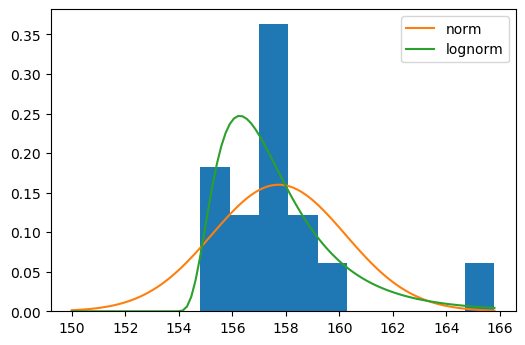

In [19]:
###
# TASK: Fit two marginals and compare them both against the data
###
mg_norm = gr.marg_named(df_ruff.TYS, "norm")
mg_lognorm = gr.marg_named(df_ruff.TYS, "lognorm")

## NOTE: No need to edit; use this to check your work
# Visualize
TYS = np.linspace(150, df_ruff.TYS.max(), num=100)
d_norm = list(map(lambda x: mg_norm.l(x), TYS))
d_lognorm = list(map(lambda x: mg_lognorm.l(x), TYS))

plt.hist(df_ruff.TYS, density=True)
plt.plot(TYS, d_norm, label="norm")
plt.plot(TYS, d_lognorm, label="lognorm")
plt.legend(loc=0)


*Observe*:

- Between the two models---normal or lognormal---which *better* respects the *known physical principles* of the TYS?
  - Both models stretch to -inf and inf which the real world data would not reflect. However, the lognorm decays quicker when approaching 0 which means it represents the physical principles slightly better. 
- Which model---if either---*better* fits the TYS data?
  - The lognorm more accurately reflects the distribution of the data while the norm more accurately reflects the mean of the data. Depending on your design goals, either of these distributions could be argued to better reflect the model. 
- Between the two models---normal or lognormal---which would you *choose* to represent TYS? On what grounds?
  - The lognorm because it fits distribution of the data better. 
*Aside*:

A more formal way to assess the fit of a distribution would be to study a [qq plot](https://en.wikipedia.org/wiki/Q%E2%80%93Q_plot). Such techniques are covered in upper-level statistics courses.


Next we'll construct a first-pass a modeling a distribution for TYS and TUS.


### __q2.6__ First-pass model

Fit a copula-marginal model for the TYS and TUS data. Your model must satisfy the following requirements:

Requirements:

- Lognormal marginals for `TYS` and `TUS`.
- A gaussian copula relating `TYS` and `TUS`.

Once done, answer the questions below.


eval_monte_carlo() is rounding n...
Design runtime estimates unavailable; model has no timing data.


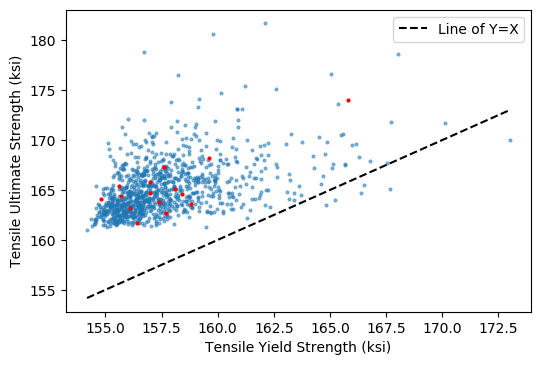

In [20]:
###
# TASK: Fit a copula-marginal model; 
#       inspect the results and answer the questions
###

# md_strength1 = ???
md_strength1 = (
    gr.Model()
    >> gr.cp_marginals(
        # Fit a "norm" (normal == gaussian) distribution for Q
        TYS=gr.marg_named(df_ruff.TYS, "lognorm"),
        # Fit a "norm" (normal == gaussian) for omega0
        TUS=gr.marg_named(df_ruff.TUS, "lognorm"),
    )
    # Fit a gaussian copula to introduce dependence
    >> gr.cp_copula_gaussian(df_data=df_ruff)
)

## NOTE: No need to edit; use this to check your work
# Draw samples
df_s1 = (
    md_strength1
    >> gr.ev_monte_carlo(n=1e3, df_det="nom", skip=True, seed=101)
)

# Visualize
plt.plot(df_s1.TYS, df_s1.TUS, ".", markersize=4, alpha=1/2)
plt.plot(df_ruff.TYS, df_ruff.TUS, "r.", markersize=4)
plt.plot(
    [df_s1.TYS.min(), df_s1.TYS.max()],
    [df_s1.TYS.min(), df_s1.TYS.max()],
    "k--",
    label="Line of Y=X"
)
plt.xlabel("Tensile Yield Strength (ksi)")
plt.ylabel("Tensile Ultimate Strength (ksi)")
plt.legend(loc=0)

*Observe*:

- Do the observations from this random variable model satisfy the physical constraints we discussed above? Why or why not?
  - While there are no negative values, there are cases where the ultimate strength is less than the yield strenght which breaks the physical constraints. 


### Data transformation

We set out to respect certain physical principles in our random variable model; to do this, we'll need to use some modeling tricks to enforce physical constraints. Here's the strategy we'll use:

- Transform the data to relate `TYS` and `TUS`; this will introduce a new variable `T_off`.
- Model `TYS` and `T_off` with a distribution, compute `TUS` from `TYS, T_off`.
- **Carefully design the distribution for `TYS` and `T_off` to enforce physical principles.**

In more detail, we write:

$$TUS = TYS + T_{off}$$

We then create a distribution $\rho$

$$[TYS, T_{off}] \sim \rho$$

The next cell carries out the data transformation:


Text(0, 0.5, 'TUS - TYS difference (ksi)')

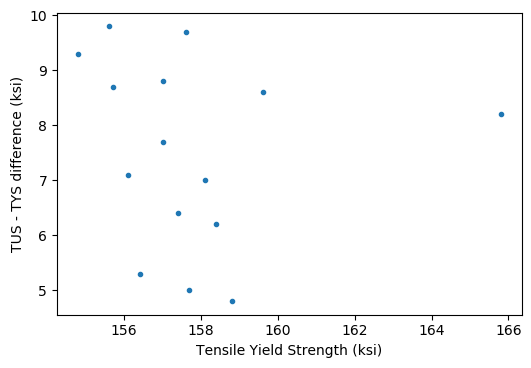

In [21]:
## NOTE: No need to edit
df_transformed = (
    df_ruff
    >> gr.tf_mutate(T_off=DF.TUS - DF.TYS)
)



plt.plot(df_transformed.TYS, df_transformed.T_off, ".")
plt.xlabel("Tensile Yield Strength (ksi)")
plt.ylabel("TUS - TYS difference (ksi)")


Note that the difference term no longer exhibits the strong correlation we saw before. Let's inspect its marginal to inform a choice of distribution for `T_off`.


Text(0.5, 0, 'TUS - TYS Difference (ksi)')

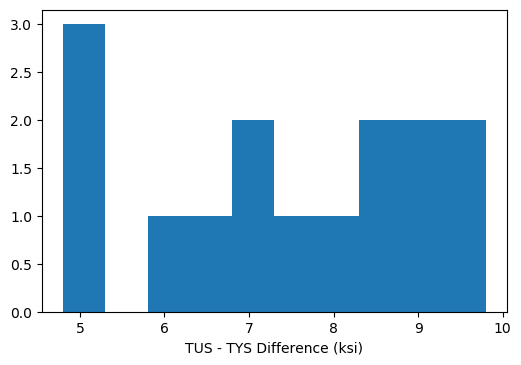

In [22]:
## NOTE: No need to edit
plt.hist(df_transformed.T_off)
plt.xlabel("TUS - TYS Difference (ksi)")


You'll use this information to inform a choice for `T_off` in the next task.


### __q2.7__ Fit a transformed model

Complete the modeling process on your own. Carry out the following steps:

- Choose an appropriate marginal shape for `T_off`.
- Fit a copula-marginal model for `TYS, T_off`.
- Add a function to map `TYS, T_off` back to `TUS`.

Once you're satisfied with your model, answer the questions below.


   part    TYS    TUS  thickness  T_off
0    aa  157.0  164.7      0.485    7.7
1    ab  159.6  168.2      0.625    8.6
2    ac  155.6  165.4      0.625    9.8
3    ha  165.8  174.0      0.375    8.2
4    hb  157.4  163.8      1.000    6.4
5    hc  158.4  164.6      0.500    6.2
6    hd  157.6  167.3      0.150    9.7
7    ba  156.4  161.7      3.000    5.3
8    bb  157.7  162.7      3.000    5.0
9    ga  155.7  164.4      0.500    8.7
10   gb  158.8  163.6      0.500    4.8
11   gc  158.1  165.1      0.500    7.0
12   gd  157.0  165.8      0.500    8.8
13   ge  154.8  164.1      0.500    9.3
14   gf  156.1  163.2      0.375    7.1
eval_monte_carlo() is rounding n...
        T_off         TYS         TUS
0    7.653338  157.244452  164.897790
1    5.657608  154.948072  160.605680
2    8.969484  158.200354  167.169838
3    9.268065  156.340506  165.608572
4    5.749695  158.463489  164.213184
5    6.560660  157.431689  163.992348
6    8.728009  155.825015  164.553024
7    5.961768  162.9

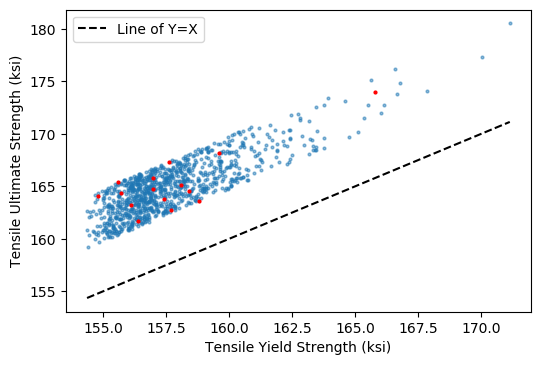

In [23]:
###
# TASK: Fit a copula-marginal model, and create a function to
#       compute TUS from TYS, T_off. Answer the questions below
###

# md_strength2 = ???
md_strength2 = (
    gr.Model()     
    >> gr.cp_vec_function(
        fun=lambda df: gr.df_make(TUS= df.TYS + df.T_off),
        var=["TYS", "T_off"],
        out=["TUS"],
    )
    >> gr.cp_marginals(
        TYS=gr.marg_named(df_transformed.TYS, "lognorm"),
        T_off=gr.marg_named(df_transformed.T_off, "uniform"),
    )
    # Fit a gaussian copula to introduce dependence
#     >> gr.cp_copula_gaussian(df_data=df_transformed)
    >> gr.cp_copula_independence()

)
print(df_transformed)
## NOTE: No need to edit; use this to check your work
# Draw samples
df_s2 = (
    md_strength2
    >> gr.ev_monte_carlo(n=1e3, df_det="nom", seed=101)
)
print(df_s2)
# Visualize
plt.plot(df_s2.TYS, df_s2.TUS, ".", markersize=4, alpha=1/2)
plt.plot(df_ruff.TYS, df_ruff.TUS, "r.", markersize=4)
plt.plot(
    [df_s2.TYS.min(), df_s2.TYS.max()],
    [df_s2.TYS.min(), df_s2.TYS.max()],
    "k--",
    label="Line of Y=X"
)
plt.xlabel("Tensile Yield Strength (ksi)")
plt.ylabel("Tensile Ultimate Strength (ksi)")
plt.legend(loc=0)


*Observe*:

- Do the observations from this random variable model satisfy the physical constraints we discussed above? Why or why not?
  - Yes, there are no negative values and the ultimate strength is always greater than the yield strength. 
- Does your model satisfy the physical constraints for *all* possible observations? Why or why not?
  - No, it's still possible for the yield strength to be negative, just highly unlikely. 


### Nice work!

Congratulations! You've just carried out your first probability modeling exercise. This might have seemed kind of strange, but I hope it gives you a "flavor" for what modeling with random variables "feels like." It may feel like "cheating" to introduce a new variable like `T_off`, but this is a fairly general approach. Keep this idea in mind for your project in case you need to model random quantities that have known physical behaviors you want to respect.

### Aside: What if you don't have data?

The ideal setting with probability modeling is to use repeated observations from the same distribution. However, in many circumstances you will not have samples on every variable to use this approach. You may instead need to set manual correlation values. Note that you can do this through the `df_corr` argument in `cp_copula_gaussian()` by specifying the pairwise correlations. The following example illustrates how:


eval_monte_carlo() is rounding n...
Design runtime estimates unavailable; model has no timing data.
Calling plot_scattermat....


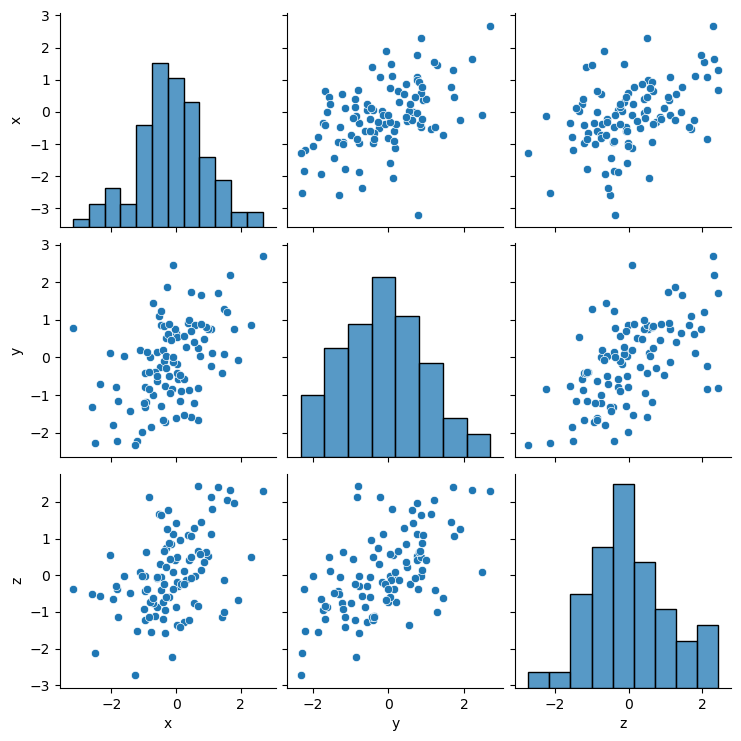

In [24]:
## NOTE: No need to edit
md_corr_example = (
    gr.Model("Correlation example")
    >> gr.cp_marginals(
        x=dict(dist="norm", loc=0, scale=1),
        y=dict(dist="norm", loc=0, scale=1),
        z=dict(dist="norm", loc=0, scale=1),
    )
    >> gr.cp_copula_gaussian(
        df_corr=gr.df_make(
            var1=["x", "x", "y"],
            var2=["y", "z", "z"],
            corr=[0.5, 0.5, 0.5],
        )
    )
)

(
    md_corr_example
    >> gr.ev_monte_carlo(n=1e2, df_det="nom", skip=True)
    >> gr.pt_auto()
)

Note that you may not even have correlations to fix between random quantities in your model. In this case, you may need to *test multiple scenarios* of correlation, and report your analysis / optimization results under these different scenarios. You'll do some planning on this in the Project task below.


To finish off this notebook, we'll use your model `md_strength2` to study the safety of cast-steel structures.


## S3: Reliability

---

**Reliability** has a technical definition; it is one minus the probability of failure (pof) for a given structure. In the reliability community, we introduce some formalism to help carry out a reliability analysis.

The **limit state function** $g(d, X)$ is a function that collects all the design variables $d$ and random variables $X$ for a system and organizes them into a single constraint function. The meaning of $g$ is as follows:

| Case | Result |
|---|---|
| `g(d, X) > 0` | Safe operation |
| `g(d, X) <= 0` | Failure |

An example of a limit state function is the simple stress criteria we've discussed before; if we have an applied stress $\sigma_{\text{app}}(d, X)$ and a (random) strength $\sigma_y$, then the limit state is

$$g_{\text{stress}}(d, X) = \sigma_y - \sigma_{\text{app}}(d, X),$$

where $\sigma_y$ is one of our random variables in the vector $X$.

Using the limit state definition, the **reliability** is defined as:

$$R(d) = \mathbb{P}_X[g(d, X) > 0],$$

while the probability of failure (pof) is

$$F(d) = 1 - R(d).$$

For various reasons (including approximation techniques like FORM), we also define the *reliability index* $\beta$ as a third way to express reliability information

$$\beta(d) = \Phi^{-1}(R(d)) = \Phi^{-1}(1 - F(d)),$$

where $\Phi$ is the standard normal CDF. The reliability index is, among other things, a convenient way to express small probabilities; for instance, $\beta = 2$ corresponds to $F \approx 0.023$ and $\beta = 3$ corresponds to $F \approx 0.0013$.

Reliability is a key consideration for safety-critical systems. A higher reliability (lower pof) corresponds to a safer system. Some industries have federally-mandated reliability requirements for structures; for example see del Rosario (2021) for info on aircraft reliability.


### Estimating reliability

We can estimate reliability with Monte Carlo

$$R(d) = \mathbb{P}_X[g(X, d) > 0] \approx \sum_{i=1}^n \frac{1(g(X_i, d) > 0)}{n} = \frac{\text{# Successes}}{\text{# Total}}$$

Above we assumed that the `TYS` and `TUS` values all came from the same population (identically distributed). If we further assume that the samples are independent, then we can treat the dataset `df_ruff` as a Monte Carlo sample, and use it to estimate the pof. You'll do this in the next task.


### __q3.1__ Compare multiple estimates

Treat the dataset `df_ruff` as a set of independent, identically-distributed samples, and approximate the probability of tensile yield failure when $\sigma_{\text{app}} = 154.5$ ksi. Carry out the same estimation using your model `md_strength2`.

*Hint*: For the `df_ruff` approach, you should use `gr.tf_summarize()` with `gr.mean()`, similar to the Monte Carlo approach. You did this in A4 q2.2.


Design runtime estimates unavailable; model has no timing data.
POF (samples) = 0.000e+00
POF (modeled) = 3.600e-03


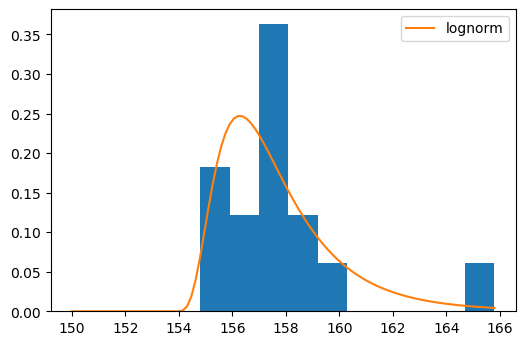

In [25]:
# # TASK: Estimate the probability of failure (POF) using:
#       - the TYS samples in df_ruff
#       - your model from q2.5 md_strength2
###

sigma_applied = 154.5 # Applied stress, for POF calculation
df_ruff.fail = df_ruff.TYS < sigma_applied
fail_count = df_ruff.fail[df_ruff.fail == True].count()
pof_samples = (fail_count/df_ruff.shape[0])




df_3_1 = (
    md_strength2
    >> gr.ev_monte_carlo(n=5000, df_det="nom", skip=True, seed=101)
## Add a column called `bool_fail` that takes the value `True` when
## the strength is low enough to cause failure.
    >> gr.tf_mutate(
        bool_fail= DF.TYS <= 154.5
    )
    # NOTE: No need to edit; this summarizes your data
    >> gr.tf_summarize(
        pof_mu=gr.mean(DF.bool_fail),
    )

)
pof_modeled = df_3_1.pof_mu.iloc[0]


## NOTE: No need to edit; use this to check your work
print("POF (samples) = {0:4.3e}".format(pof_samples))
print("POF (modeled) = {0:4.3e}".format(pof_modeled))

assert(pof_samples <= 1e-9)

# Visualize
TYS = np.linspace(150, df_ruff.TYS.max(), num=100)
d_lognorm = list(map(lambda x: md_strength2.density.marginals["TYS"].l(x), TYS))

plt.hist(df_ruff.TYS, density=True)
plt.plot(TYS, d_lognorm, label="lognorm")
plt.legend(loc=0)

*Observe*:

- What is your POF estimate based on the physical samples? Is this a plausible estimate?
  - 0, no
- What is your POF estimate based on the distribution model? Is this a plausible estimate?
  - .0036, yes
- Based on your POF estimate using a distribution model, how many failures would you expect to see in `n = 15` observations? Would you expect to see even one failure?
  - 15 * .0036 = .054. You would most likely see 0 failures.
- Based on your POF estimate using a distribution model, how many samples would you need to collect before you would expect to see at least one failure?
  - 1 / .0036 = 278


### Estimating tail probabilities

These results illustrate an important fact: **Estimating small probabilities is difficult**, in the sense that it requires a large number of samples! We often run into small probabilities when considering the *tail* of a distribution---either the left or right extreme of a distribution. Since we generally want the pof to be small, by choice we are dealing with tail probabilities.

**A practical rule-of-thumb**: If you're trying to estimate a probability of failure *without modeling*, you'll need about $n > \frac{10}{POF}$ samples. With a distribution model, one can use fewer samples: For aircraft material properties, standard practice demands at least $n = 100$ samples when using a model, and $n = 299$ when not using a model.

The next task will help you build intuition with Monte Carlo for tail probabilities.


### __q3.2__ Estimate tail probabilities with Monte Carlo

Use your model `md_strength2` to estimate the POF of the ultimate failure mode when the applied stress is `sigma_ult = 160`. Use the Monte Carlo approach with two sample sizes: 1. `n = 15`, the size of `df_ruff`, and 2. using the *rule of thumb* noted above, based on the POF you estimated for the `TYS` failure criteria.


In [26]:
###
# TASK: Estimate the pof using the two sample sizes specified above
###

sigma_ult = 160. # Applied stress for ultimate failure mode

df_pof_limited = (
    md_strength2
    >> gr.ev_monte_carlo(n=15, df_det="nom", seed=101)
## Add a column called `bool_fail` that takes the value `True` when
## the strength is low enough to cause failure.
    >> gr.tf_mutate(
        bool_fail= DF.TUS <= sigma_ult
    )
    # NOTE: No need to edit; this summarizes your data
    >> gr.tf_summarize(
        pof_mu=gr.mean(DF.bool_fail),
    )

)
df_pof = (
    md_strength2
    >> gr.ev_monte_carlo(n=3334, df_det="nom", seed=101)
## Add a column called `bool_fail` that takes the value `True` when
## the strength is low enough to cause failure.
    >> gr.tf_mutate(
        bool_fail= DF.TUS <= sigma_ult
    )
    # NOTE: No need to edit; this summarizes your data
    >> gr.tf_summarize(
        pof_mu=gr.mean(DF.bool_fail),
    )

)


## NOTE: No need to edit; use this to compare results
print("Limited:\n{}".format(df_pof_limited))
print("Refined:\n{}".format(df_pof))

Limited:
   pof_mu
0     0.0
Refined:
     pof_mu
0  0.004199


*Observe*:

- Imagine that you were analyzing a more complex model that required a simulation for every run in your `n` Monte Carlo evaluations, such as a FEA or circuit analysis. Further suppose that each simulation took $1$ second to execute. How long would estimating the POF take? 
  - It would take n seconds to run. If we were following the rule of POF/10, it would take 3,334 seconds or just under an hour. 
- Further suppose that you only needed to carry out a *single* analysis of your system; you just need to accurately estimate the POF of the system as it is currently designed. Would this be practical, based on your chosen `n`? Why or why not?
  - Yes, if you only have to run the analysis once because everything else is finalized, you know that it will only take an hour and it would be an easy task to run the in the background while you focus on something else.
- Now suppose that you want to use the POF data to carry out optimization using something like gradient descent. In this setting, every time you adjust the design variables you will have to re-run the Monte Carlo to update the POF estimate. Would your chosen `n` be practical for this setting? Why or why not?
  - No, this would significantly hamper any progress. There could be dozen of design changes that would now take at least an hour to implement: this could even force you to pick a non-optimal design to save time.


These results indicate that Monte Carlo is a very expensive way to assess reliability! To deal with this limitation, we'll use a different approximation technique: The *first-order reliability method*.

### The First-Order Reliability Method (FORM)

As we discussed in class, the first-order reliability method (FORM) is an approximation technique that relies on a few assumptions:

- We can transform our random variables $X$ to standard-normal variables $Z$.
- We can accurately approximate the failure surface ${Z \,|\, g(Z) = 0}$ as a hyperplane (first-order approximation).

Under this set of approximations, the reliability problem becomes a *most-probable point* search (an optimization problem!):

$$\min\, \|Z\|_2$$
$$\text{wrt.}\, Z$$
$$\text{s.t.}\, g(Z) = 0$$

Part of the advantage of setting up your probability model in Grama is that the framework takes care of the transformation to standard normal space $Z$ *automatically*. Below you'll practice using Grama's FORM routines to assess the reliability of a model.


### __q3.3__ Use FORM to assess the POF; Assess scalability

The following code calls the FORM routine in Grama. Your task is to compute the POF from the reliability index $\beta$ computed below. Answer the questions under *Observe* below.

*Hint*: The function `gr.pnorm()` implements $\Phi(\cdot)$.


For various reasons (including approximation techniques like FORM), we also define the *reliability index* $\beta$ as a third way to express reliability information

$$\beta(d) = \Phi^{-1}(R(d)) = \Phi^{-1}(1 - F(d)),$$

where $\Phi$ is the standard normal CDF. The reliability index is, among other things, a convenient way to express small probabilities; for instance, $\beta = 2$ corresponds to $F \approx 0.023$ and $\beta = 3$ corresponds to $F \approx 0.0013$.

In [30]:
###
# TASK: Transform the reliability index beta_g into
#       a probability of failure
###

## NOTE: You only need to add one line to the following:
# print(md_strength2)
(
    md_strength2
    >> gr.cp_vec_function(
        fun=lambda df: gr.df_make(g=df.TUS - sigma_ult),
        var=["TUS"],
        out=["g"]
    )
    >> gr.ev_form_ria(df_det="nom", limits=["g"], verbose=True)
    ## TASK: Compute the POF from beta_g
    # more than one line of code :(
    >> gr.tf_summarize(
        pof = 1 - gr.pnorm(DF.beta_g)
    )
)

out = g: Optimization successful
n_iter = 8
n_iter_total = 8


,pof
0,[0.005994234967791723]


*Observe*:

- How does the POF estimated via FORM compare with what you computed using Monte Carlo above?
  - the FORM has a higher prob of failure.
- How many *iterations* did it take to estimate the POF in this case? How many *function evaluations* use in comparison with the Monte Carlo approach above? (*Note*: A single optimization iteration uses a small number of function evaluations; thus `n_iter` is not *directly* comparable to `n` from Monte Carlo.)
  - ev_form_ria printed out n_iter_total = 8, Monte carlo had n = 3334. 


### Forward vs Inverse Approach

Clearly FORM is a far more scalable way to approximate reliability! Using FORM, we could apply a reliability constraint in optimization via $\beta(d) \geq \beta_{\text{desired}}$. Unfortunately, there's one more trick we need to make this approach tractable....

It is far more common to use an *inverse* approach to FORM when using the technique for design. This amount to fixing a desired reliability level $\beta_{\text{desired}}$ and solving for the quantile of the limit state that satisfies this reliability $g^*(d)_{\beta = \beta_{\text{desired}}}$. We then apply our reliability constraint by setting $g^*(d)_{\beta = \beta_{\text{desired}}} \geq 0$.

As a simple illustration, let's consider the case where

$$g(A) = \sigma_{ult} - 200\text{ kips} / A.$$


### __q3.4__ Compare the RIA and PMA approaches

Suppose we sought to solve the following optimization problem:

$$\min_A\, \text{cost} = A$$
$$\text{s.t.}\, \beta(A) \geq 3.0$$

Transforming to the performance measure approach (PMA), this becomes:

$$\min_A\, \text{cost} = A$$
$$\text{s.t.}\, g^*(A)_{\beta=3.0} \geq 0$$

As a first step we carry out a sweep of analyses across different values of $A$. Inspect the results below and answer the questions under *Observe*.


In [28]:
###
# TASK: Run the following code, inspect the results, 
#       answer the questions below
###

## NOTE: No need to edit; run and inspect
df_ria = (
    md_strength2
    >> gr.cp_vec_function(
        fun=lambda df: gr.df_make(g=df.TUS - 200 / df.A),
        var=["TUS", "A"],
        out=["g"]
    )
    >> gr.ev_form_ria(df_det=gr.df_make(A=[0.1, 0.5, 1.0, 1.5, 2.0]), limits=["g"])
)

df_pma = (
    md_strength2
    >> gr.cp_vec_function(
        fun=lambda df: gr.df_make(g=df.TUS - 200 / df.A),
        var=["TUS", "A"],
        out=["g"]
    )
    >> gr.ev_form_pma(df_det=gr.df_make(A=[0.1, 0.5, 1.0, 1.5, 2.0]), betas=dict(g=3.0))
)

print("RIA approach:\n{}\n".format(df_ria))
print("PMA approach:\n{}".format(df_pma))


RIA approach:
     A         TYS     T_off    beta_g
0  0.1         NaN       NaN       NaN
0  0.5         NaN       NaN       NaN
0  1.0  191.937641  8.062351  4.435232
0  1.5         NaN       NaN       NaN
0  2.0         NaN       NaN       NaN

PMA approach:
     A         TYS     T_off            g
0  0.1  154.664518  4.974693 -1840.360789
0  0.5  154.664519  4.974691  -240.360789
0  1.0  154.664520  4.974691   -40.360789
0  1.5  154.664519  4.974692    26.305877
0  2.0  154.664520  4.974691    59.639211


*Observe*:

- Based on the results above, where does the optimum $A^*$ lie? (A range of values is fine)
  - between 1 and 2 
- Between the RIA and PMA approaches, which is more stable? (*Note*: A `NaN` value indicates that the underlying optimization failed)
  - PMA
- Imagine you were trying to assess the reliability of a given design. Which FORM implementation would be more effective: The RIA or PMA approach?
  - PMA
- Imagine you were trying to optimize for a desired reliability level. Which FORM implementation would be more effective: The RIA or PMA approach? How would you construct the reliability constraint?
  - The RIA returned a higher value with beta closer to 3 so I'm assuming that's more effective. The reliability constraint would be defined in beta as $\Phi^{-1}(R(d))$.


### (Bonus) Perform design with the PMA approach

The following code implements a design optimization using the PMA.


In [29]:
## NOTE: No need to edit; here's a recipe for doing design with the PMA
# Define an "inner" model with uncertainty
md_inner = (
    md_strength2
    >> gr.cp_vec_function(
        fun=lambda df: gr.df_make(g=df.TUS - 200 / df.A),
        var=["TUS", "A"],
        out=["g"]
    )
)

# Wrap that inner model with a call to FORM; 
# the resulting model should have deterministic variables *only*
md_opt = (
    gr.Model()
    >> gr.cp_vec_function(
        fun=lambda df: gr.df_make(cost=df.A),
        var=["A"],
        out=["cost"]
    )
    >> gr.cp_vec_function(
        fun=lambda df: gr.eval_form_pma(
            md_inner,
            df_det=df,
            betas=dict(g=3.0)
        ),
        var=["A"],
        out=["g"]
    )
    >> gr.cp_bounds(A=(1.0, 2.0))
)

# Run the optimization
df_opt = (
    md_opt
    >> gr.ev_min(out_min="cost", out_geq=["g"])
)
df_opt

,A,A_0,g,cost,success,message,n_iter
0,1.252825,1.5,-8.366499e-10,1.252825,True,Optimization terminated successfully.,5


## Project

---

### __Project Task__

Look back on your project idea from the previous assignment. As we saw in this assignment, many problems have uncertainties that complicate design. This project task will help you connect these ideas to your project.

*Task*: Provide an answer to each point below:

- *Variables and Parameters*: Copy the *Variables and Parameters* notes you took in the previous notebook. Note which terms are uncertain / random.
  - Variables: (Your response here)
  - Parameters: (Your response here)
- *Dependencies*: What---if any---dependencies are there between the random quantities in your project? Do you have data available to fit correlations? Do you have literature that describes the relationship between quantities? Or do you have no information?
  - Remember that you can only use an independence copula in your problem if you can **guarantee** that **every** random quantity in your problem is independent.

*Note*: Adapt the following table to help track dependencies between variables:

| Quantity 1 | Quantity 2 | Dependency | Info? |
|---|---|---|---|
| X | Y | Related | Data |
| X | Z | Related | Literature |
| X | U | Independent | NA |
| Y | Z | Related | Literature |
| Y | U | Independent | NA |
| Z | U | Independent | NA |
| ... | ... | (And so on) | NA |

- *Scenarios*: It's likely that you don't have data on *every* possible dependency between random quantities in your project. This means you'll have to study different scenarios of dependency between quantities, in order to determine their effects on your optimization results. Note how many dependencies you don't have information on, and start sketching out a plan to test different scenarios.
  - (Your response here)


## References

- Ruff, Paul E. (1984) An Overview of the MIL-HDBK-5 Program. BATTELLE COLUMBUS DIV OH.
- del Rosario, Fenrich, and Iaccarino (2021) "When are Allowables Conservative?" *AIAA Journal*
- MMPDS-04 : Metallic materials properties development and standardization (MMPDS)
